In [1]:
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

import cv2
# for loading in images

%matplotlib inline

In [2]:
im_list_green=[]

for file in glob.glob("trafficLightImages/total/green/*"): #note that my dataset contains all the data and is split with sklearn
    # the file directory contains all the 
    # Read in the image
    im = mpimg.imread(file)   
            
    # Append the image to the green image list
    im_list_green.append(im)
    
print(len(im_list_green))

im_list_red=[]

for file in glob.glob("trafficLightImages/total/red/*"):
    
    # Read in the image
    im = mpimg.imread(file)   
            
    # Append the image to the green image list
    im_list_red.append(im)
    
print(len(im_list_red))

im_list_yellow=[]

for file in glob.glob("trafficLightImages/total/yellow/*"):
    
    # Read in the image
    im = mpimg.imread(file)   
            
    # Append the image to the green image list
    im_list_yellow.append(im)
    
print(len(im_list_yellow))

for image in im_list_yellow:
    plt.imshow(image)
    #plt.show()

print(im_list_green[0].shape)
print(len(im_list_green[0]))
print(len(im_list_green[0][1]))
print(len(im_list_green[0][1][2]))
# print("73", im_list_green[0])
# print("46", im_list_green[1])
# print("3", im_list_green[2])

536
904
43
(75, 46, 3)
75
46
3


In [3]:
for image in im_list_yellow:
    plt.imshow(image)
    #plt.show()

In [4]:
# This function should take in an RGB image and return a new, standardized version
def standardize_input(image):
    image_crop = np.copy(image)
    row_crop = 7
    col_crop = 8
    image_crop = image[row_crop:-row_crop, col_crop:-col_crop, :]
    ## TODO: Resize image and pre-process so that all "standard" images are the same size
    standard_im = cv2.resize(image_crop, (32, 32))
    return standard_im

In [5]:
#!pip install opencv-python

 # helper functions

std_img = standardize_input(im_list_green[2])

In [6]:
std_img_list_red=[]

for image in im_list_red:
    std_img = standardize_input(image)
    std_img_list_red.append((std_img,0)) # red light is class 0 storing as a tuple.
    plt.imshow(std_img)
    #plt.show()

std_img_list_green=[]

for image in im_list_green:
    std_img = standardize_input(image)
    std_img_list_green.append((std_img,1)) # green light is class 1 storing as a tuple.
    plt.imshow(std_img)
    #plt.show()


std_img_list_yellow=[]

for image in im_list_yellow:
    std_img = standardize_input(image)
    std_img_list_yellow.append((std_img,2)) # yellow light is class 2 storing as a tuple.
    plt.imshow(std_img)
    #plt.show()
#print(type(image))

In [7]:
def preprocess_images(image_list):
    # First create a list to store standardized images
    standardized_images = []
    
    # Standardize each image first
    for img in image_list:
        std_img = standardize_input(img)  # Using your existing standardize_input function
        standardized_images.append(std_img)
    
    # Convert list to numpy array and normalize to [0,1] range
    images = np.array(standardized_images).astype('float32') / 255.0
    
    # Standardize images (zero mean and unit variance)
    mean = np.mean(images, axis=0)
    std = np.std(images, axis=0)
    images = (images - mean) / (std + 1e-7)  # adding small epsilon to avoid division by zero
    
    # Flatten the images for SVC
    # Reshape from (n_samples, height, width, channels) to (n_samples, height*width*channels)
    n_samples = images.shape[0]
    images_flat = images.reshape(n_samples, -1)
    
    return images_flat

# Process each color category
print("Processing green images...")
green_processed = preprocess_images(im_list_green)
print("Processing red images...")
red_processed = preprocess_images(im_list_red)
print("Processing yellow images...")
yellow_processed = preprocess_images(im_list_yellow)

# Create labels
green_labels = np.zeros(len(im_list_green))
red_labels = np.ones(len(im_list_red))
yellow_labels = np.full(len(im_list_yellow), 2)

# Combine data
X = np.concatenate([green_processed, red_processed, yellow_processed])
y = np.concatenate([green_labels, red_labels, yellow_labels])

# Shuffle data
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Print shapes to verify
print("\nFinal shapes:")
print("X shape:", X.shape)
print("y shape:", y.shape)

Processing green images...
Processing red images...
Processing yellow images...

Final shapes:
X shape: (1483, 3072)
y shape: (1483,)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.2, random_state=20, stratify=y) # test_train_split splitting data into 80% for training and 20% for test

In [9]:
X.shape

(1483, 3072)

# SVM with rbf kernal

In [10]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf') # RBF is stronger for non-linear data, I find it is more powerful.

In [11]:
type(X)

numpy.ndarray

In [12]:
import numpy as np


svm.fit(X_train, y_train) # many iterations, simple without hyperparameters produces the best result.



SVC()

In [13]:
type(y_train)
#print(y_train)

numpy.ndarray

In [14]:
#y_validation

In [15]:
from sklearn import metrics 
y_pred = svm.predict(X_validation)
print(metrics.accuracy_score(y_validation, y_pred))

0.9494949494949495


In [16]:
from sklearn.metrics import confusion_matrix

In [17]:
confmat = confusion_matrix(y_validation, y_pred)
print("Confusion Matrix: \n", confmat)
print("Total Testing Amount: \n",len(y_validation))
# data change!
# I deleted one specific yellow light that was skewing the data, the F1 score for yellow went from 62% to 88%
# This photo had some object below the yellow light with a light green shade, thus skewing the information so I removed it
# and the model was more powerful, perhaps in the real world I cannot do this.

Confusion Matrix: 
 [[101   6   0]
 [  0 181   0]
 [  4   5   0]]
Total Testing Amount: 
 297


In [18]:

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(classification_report(y_validation, y_pred))
confmat = confusion_matrix(y_validation, y_pred)
print(confmat)
print()
print('Accuracy: %.3f' % accuracy_score(y_true=y_validation, y_pred=y_pred))
print('Precision: %.3f' % precision_score(y_true=y_validation, y_pred=y_pred, average='macro'))
print('Recall: %.3f' % recall_score(y_true=y_validation, y_pred=y_pred, average='macro'))
print('F1: %.3f' % f1_score(y_true=y_validation, y_pred=y_pred, average='macro'))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       107
         1.0       0.94      1.00      0.97       181
         2.0       0.00      0.00      0.00         9

    accuracy                           0.95       297
   macro avg       0.63      0.65      0.64       297
weighted avg       0.92      0.95      0.93       297

[[101   6   0]
 [  0 181   0]
 [  4   5   0]]

Accuracy: 0.949
Precision: 0.635
Recall: 0.648
F1: 0.641


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa

In [19]:
def cross_entropy(predictions, targets, epsilon=1e-10):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce_loss = -np.sum(targets * np.log(predictions + 1e-5)) / N
    return ce_loss

cross_entropy_loss = cross_entropy(y_pred, y_validation)
print("Cross entropy loss is: " + str(cross_entropy_loss))

Cross entropy loss is: 0.3101057701980187


 ## Analysis of SVM Model:
 
 The primary goal is to have no red light miss-classifications. Red light missclassifcations are the most dangerous when riding in a self driving car. If there is a green light missclassifcation then the car might get honked at, but then the user can interact and have the car continue driving. This SVM model performs exceptionally well, it miss classifies one green light, and has amazing F1 and recall scores as well. Yellow, has the most missclassifications and I am convinced it is because yellow is in between green and red and also the lowest amount of data. This means that in future iterations of this project getting more yellow light data would be a good addtion.
 
The cross entropy loss went from ~ 0.0479 to 0.03875, with the goal having this number as close to 0 (1 menaing all entropic, 0 meaning 0 entropy.) for an accurate number increasing the amount of data produced a more accuarate model. Overall accuracy is 99%.

I tested this off of 297 total images split from the test_train_split module in sklearn.

While this data is linearly seperable, as in, it is possible to draw a line that seperates the lights, the kernal set to RBF is meant for non linear seperable data but I also find it works well with high-dimensionality datasets. Linear results in a 5% lower accuracy.

# CNN w/ tf

In [21]:
#pip install tensorflow

from tensorflow import keras
import tensorflow as tf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 MB 4.7 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 4.2 MB/s eta 0:00:00 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 4.7 MB/s eta 0:00:00a 0:00:01mm


In [22]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 10 # keeping values at default, but changing epochs to 10 because 20 was overfitting.

In [23]:
tf.random.set_seed(3) #SO this is reproducable.

In [25]:

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(3, 3),
    strides=(1, 1), padding='valid',
    input_shape=(32, 32, 3), # the image is 32 x 32 x 3, (3 for RGB)
    name='conv_1', activation='relu')) # the output is smaller because of the operation reuducing dimensions

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2), name='pool_1'))

model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), # applies 64 filters that are 3x3 in size
    strides=(1, 1), padding='valid', # low stride for maximum reiteration over an image
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')) # reducing the dimension size by half

model.add(tf.keras.layers.Flatten(name='flatten')) # flattens to 1D array 

model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', # fully connected 2304 values to 1024 neurons.
    activation='relu'))

model.add(tf.keras.layers.Dropout(rate=0.5, name='dropout'))

model.add(tf.keras.layers.Dense(
    units=3, name='fc_2', #  1024 weights connects to 3 output neurons for each class.
    activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,382,787 (9.09 MB)

 Trainable params: 2,382,787 (9.09 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
print(X_train.shape)
print(y_train.shape)

(1186, 3072)
(1186,)


In [27]:
X_train = X_train[:len(X_validation)] # makes validation and training the significantly smaller size, this prevents overfitting.
y_train = y_train[:len(y_validation)]

# choice to keep this commented or not. chose not.

In [28]:

X_validation.shape
X_train.shape #must use -1 to make it None

(297, 3072)

In [29]:
y_validation.shape

(297,)

In [30]:
# X_train = tf.convert_to_tensor(X_train)
# y_train = tf.convert_to_tensor(y_train)
# X_validation = tf.convert_to_tensor(X_validation)
# y_validation = tf.convert_to_tensor(y_validation)

X_train = tf.reshape(X_train, [-1, 32, 32, 3])
X_validation = tf.reshape(X_validation, [-1, 32, 32, 3])
#print(X_train)
#print(X_validation) 


# I needed to reshape after making a dataframe. Before when I was using a list, it was already
# in the right shape.

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(), # using adam instead of gradient descient, Adam performs better
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`


history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, validation_data=(X_validation, y_validation), shuffle=True)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - accuracy: 0.6756 - loss: 0.8307 - val_accuracy: 0.9562 - val_loss: 0.1829
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.9463 - loss: 0.1778 - val_accuracy: 0.9764 - val_loss: 0.0730
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9759 - loss: 0.0707 - val_accuracy: 0.9798 - val_loss: 0.0481
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.9897 - loss: 0.0321 - val_accuracy: 0.9832 - val_loss: 0.0354
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9966 - loss: 0.0177 - val_accuracy: 0.9865 - val_loss: 0.0490
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 0.0182 - val_accuracy: 0.9899 - val_loss: 0.0247
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 1.0000 - loss: 0.0103 - val_accuracy: 0.9966 - val_loss: 0.0175
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.

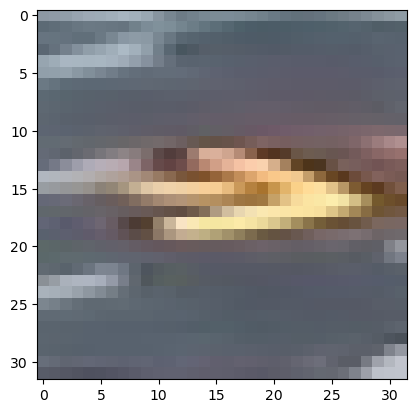

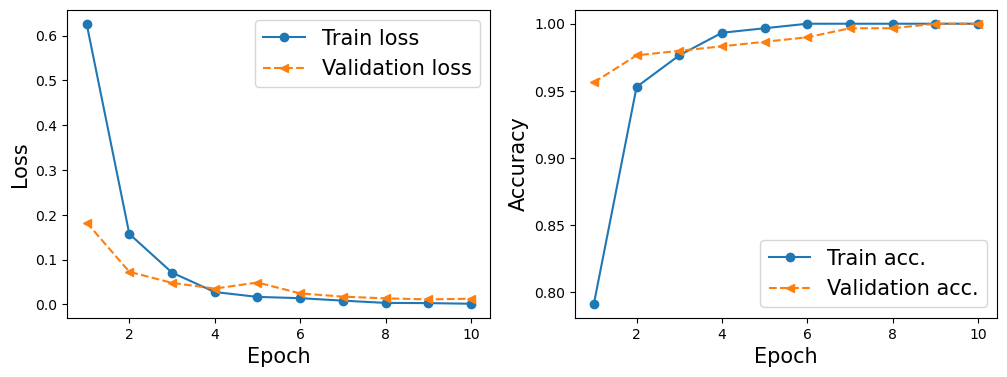

{'accuracy': [0.7912458181381226, 0.9528619647026062, 0.9764309525489807, 0.9932659864425659, 0.996632993221283, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [0.6263365745544434, 0.15739880502223969, 0.07106488943099976, 0.027747083455324173, 0.016914524137973785, 0.014065088704228401, 0.008564483374357224, 0.0034863234031945467, 0.0029988070018589497, 0.0016663764836266637], 'val_accuracy': [0.9562289714813232, 0.9764309525489807, 0.9797979593276978, 0.9831649661064148, 0.9865319728851318, 0.9898989796638489, 0.996632993221283, 0.996632993221283, 1.0, 1.0], 'val_loss': [0.18285329639911652, 0.0729537159204483, 0.0481361523270607, 0.03543049097061157, 0.04897689074277878, 0.024738555774092674, 0.017483174800872803, 0.013623876497149467, 0.011388822458684444, 0.012777990661561489]}


In [32]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)


plt.show()
print(hist)

This is showing that the model learns really well right away with the loss being 29, it is common for losses
to be a higher number then even out.

In [33]:
print(type(history))
print(type(hist))


<class 'keras.src.callbacks.history.History'>
<class 'dict'>


In [34]:
print(model)

<Sequential name=sequential_1, built=True>


In [35]:
test_results = model.evaluate(X_validation,y_validation,batch_size=10)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0112

Test Acc. 100.00%


In [36]:
predictions_prob = model.predict(X_validation)
predictions = np.argmax(predictions_prob, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


In [37]:
conf_matrix = confusion_matrix(y_validation, predictions)
conf_matrix

array([[107,   0,   0],
       [  0, 181,   0],
       [  0,   0,   9]])

# Analysis of CNN Model:
This model performs better than the SVM model because it only miss classified yellowlights(probably because of the least amount of data), which I would say is better than 
missclassifying greenlights. The accuracy shoots up after about 5 epochs but takes the remaining 5 epochs to even out.
\
The accuracy of 99.66% is extremly high and it is what I would expect for a problem like this with the amount of parameters (2.3 million). Each parameter is an updating weight or connection to each node, this is exciting considering the cutting edge AI tech of today have upwards of around 70 billion parameters in their LLMs.

If I were to further improve this I would try to gather more diverse photos with more blue backgrounds(sky), to further generalize however with this quantity of training around 1000 photos and for around 300 testing images this is rather generalized. I found it interesting to change the architecture of the neural network and seeing the results with 32 versus 64 filters, or 
manipulating the strides, I think 1,1 works best because of the amounts of times that it iterates over the same data. Using the 13x13 portion of the photo also I finds works well, as it covers about a little less than half of the photo and probably the 3 layers of color (RGB) shows the majority of the difference.